# Proof of concept 

This is a proof of concept for the inclusion of positional uncertainty within the dwell time optimisation algorthim. The focus is on the optimisation method, and as such it is assumed that each seed radially deposits its energy purely based upon the inverse square law.

Two regions are defined, a central target region and a off centre avoid region.

## Initialisation

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from utilities import BasinhoppingWrapper, create_green_cm

In [2]:
green_cm = create_green_cm()

Create the calculation grid

In [3]:
grid_spacing = 0.1 # Was 0.1, using 0.2 to speed up for testing

x_ = np.arange(-0.5, 0.5 + grid_spacing, grid_spacing)
y_ = np.arange(-0.5, 0.5 + grid_spacing, grid_spacing)
z_ = np.arange(-0.5, 0.5 + grid_spacing, grid_spacing)

x, y, z = np.meshgrid(x_, y_, z_)
x = np.ravel(x)
y = np.ravel(y)
z = np.ravel(z)

Define the target and avoid cubes

In [4]:
def target(x, y, z):
    return (
        (x < 0.45) & (x > -0.45) & 
        (y < 0.45) & (y > -0.45) & 
        (z < 0.45) & (z > -0.45))

def avoid(x, y, z):
    return (
        (x < 0.25) & (x > 0.05) & 
        (y < 0.15) & (y > -0.15) & 
        (z < 2) & (z > -2))

target_cube = target(x, y, z)

avoid_cube = avoid(x, y, z)

target_cube = target_cube & ~avoid_cube

Display the target and avoid cubes

(-0.5, 0.49999999999999978)

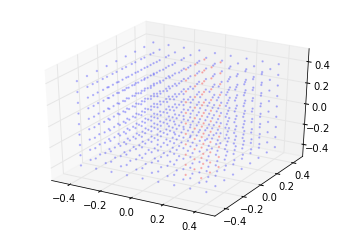

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    x[target_cube], y[target_cube], z[target_cube], 
    alpha=0.2, s=2, color='blue')
ax.scatter(
    x[avoid_cube], y[avoid_cube], z[avoid_cube], 
    alpha=0.2, s=2, color='red')

ax.set_xlim([np.min(x_), np.max(x_)])
ax.set_ylim([np.min(y_), np.max(y_)])
ax.set_zlim([np.min(z_), np.max(z_)])

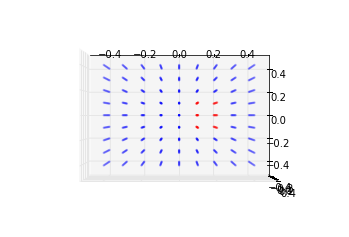

In [6]:
ax.view_init(azim=-90, elev=90)
fig

Create initial equidistant parrallel lines to represent catheters. Inbuild a slight random skew to emulate what occurs physically

In [7]:
number_of_lines = 16 # Was 16, reduced to 9 for testing

line_start = np.meshgrid(
    [-0.39, -0.13, 0.13, 0.39],
    [-0.39, -0.13, 0.13, 0.39],
    [1])

line_finish = np.array([
    line_start[0] + np.random.normal(scale=0.02, size=[4, 4, 1]),
    line_start[1] + np.random.normal(scale=0.02, size=[4, 4, 1]),
    -line_start[2]])

In [8]:
line_start = np.array([np.ravel(mesh) for mesh in line_start])
line_finish = np.array([np.ravel(mesh) for mesh in line_finish])

Display the lines overlayed

(-0.5, 0.49999999999999978)

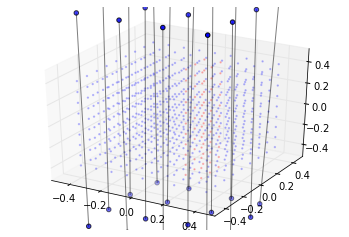

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    x[target_cube], y[target_cube], z[target_cube], 
    alpha=0.2, s=2, color='blue')
ax.scatter(
    x[avoid_cube], y[avoid_cube], z[avoid_cube], 
    alpha=0.2, s=2, color='red')
ax.scatter(*line_start)
ax.scatter(*line_finish)

for i in range(len(line_start[0])):
    plt_coords = [
        [line_start[j][i], line_finish[j][i]]
        for j in range(len(line_start))]
    ax.plot(*plt_coords, color='black', alpha=0.5)

ax.set_xlim([np.min(x_), np.max(x_)])
ax.set_ylim([np.min(y_), np.max(y_)])
ax.set_zlim([np.min(z_), np.max(z_)])

Create a function to return x, y, z coords when a distance along a line is requested

In [10]:
diff = (line_finish - line_start)
line_length = np.sqrt(diff[0]**2 + diff[1]**2 + diff[2]**2)

def find_distance_coords(line_num=None, distance=None):
    relative_dist = distance / line_length[line_num]
    
    if (relative_dist > 1) | (relative_dist < 0):
        return np.array([np.nan]*3)
    
    x = (
        line_start[0][line_num] * (1 - relative_dist) + 
        line_finish[0][line_num] * relative_dist)
    
    y = (
        line_start[1][line_num] * (1 - relative_dist) + 
        line_finish[1][line_num] * relative_dist)
        
    z = (
        line_start[2][line_num] * (1 - relative_dist) + 
        line_finish[2][line_num] * relative_dist)
    
    coords = np.array([x, y, z])
    
    return coords

Pick dwell positons starting at a random position along the line

In [11]:
dwell_spacing = 0.1 # Was 0.1, increased to 0.3 for testing
dwell_distances_from_initial = np.arange(0, 2, dwell_spacing)
number_of_dwells = len(dwell_distances_from_initial)

In [12]:
inital_dwell_position = np.random.uniform(
    low=0, high=dwell_spacing, size=number_of_lines)
inital_dwell_position

array([ 0.0778769 ,  0.03372012,  0.01040424,  0.05078169,  0.06897125,
        0.04597564,  0.01442185,  0.05148741,  0.07184905,  0.02913018,
        0.03763993,  0.08280271,  0.01029638,  0.04313421,  0.03525678,
        0.07830849])

In [13]:
dwell_distances = np.reshape(inital_dwell_position, (-1, 1)) + np.reshape(dwell_distances_from_initial, (1, -1))

In [14]:
def find_dwell_coords(line_num=None, dwell_num=None):
    distance = dwell_distances[line_num, dwell_num]
    
    coords = find_distance_coords(
        line_num=line_num, distance=distance)
    
    return coords

Find all the dwell positions that are on the grid

In [15]:
dwell_positions = np.array([
    [
        find_dwell_coords(
            line_num=line_num, dwell_num=dwell_num)
        for dwell_num in range(number_of_dwells)]
 for line_num in range(number_of_lines)])

Plot the dwell positions

In [16]:
line_colours = np.random.uniform(size=(number_of_lines,3))

(-0.5, 0.49999999999999978)

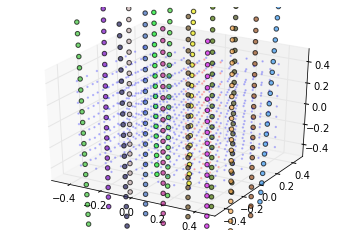

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    x[target_cube], y[target_cube], z[target_cube], 
    alpha=0.2, s=2, color='blue')
ax.scatter(
    x[avoid_cube], y[avoid_cube], z[avoid_cube], 
    alpha=0.2, s=2, color='red')

for line_num in range(number_of_lines):
    ax.scatter(*np.transpose(dwell_positions[line_num]), 
               c=line_colours[line_num], alpha=0.7)


ax.set_xlim([np.min(x_), np.max(x_)])
ax.set_ylim([np.min(y_), np.max(y_)])
ax.set_zlim([np.min(z_), np.max(z_)])

Select the dwell positions that fall withing the target region. Only use these dwell positions.

In [18]:
dwell_positions_to_be_filtered = np.reshape(dwell_positions, (-1, 3))

distance_to_dwell_pos_initial = np.array([
    np.sqrt(
        (x[i] - dwell_positions_to_be_filtered[:,0])**2 + 
        (y[i] - dwell_positions_to_be_filtered[:,1])**2 + 
        (z[i] - dwell_positions_to_be_filtered[:,2])**2
    )
    for i in range(len(x))
])

In [19]:
closest_voxel_to_dwell = np.reshape(np.argmin(distance_to_dwell_pos_initial, axis=0), [1, -1])
target_cube_voxels = np.reshape(np.where(target_cube)[0], [-1, 1])
is_dwell_closest_to_target = np.any(closest_voxel_to_dwell == target_cube_voxels, axis=0)

relevant_dwell_positions = dwell_positions_to_be_filtered[is_dwell_closest_to_target]

In [20]:
line_number_index = np.reshape(np.arange(number_of_lines), (number_of_lines, 1))
line_number_index = np.ones([number_of_lines, number_of_dwells]) * line_number_index
line_number_index = np.ravel(line_number_index)[is_dwell_closest_to_target]

(-0.5, 0.49999999999999978)

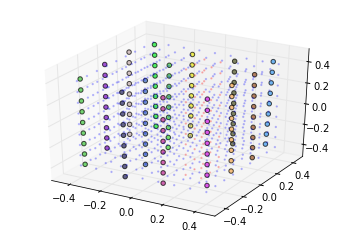

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    x[target_cube], y[target_cube], z[target_cube], 
    alpha=0.2, s=2, color='blue')

ax.scatter(
    x[avoid_cube], y[avoid_cube], z[avoid_cube], 
    alpha=0.2, s=2, color='red')

for line_num in range(number_of_lines):
    ref = line_number_index == line_num
    ax.scatter(*np.transpose(relevant_dwell_positions[ref]), 
               c=line_colours[line_num], alpha=0.7)

ax.set_xlim([np.min(x_), np.max(x_)])
ax.set_ylim([np.min(y_), np.max(y_)])
ax.set_zlim([np.min(z_), np.max(z_)])



## Initial optimisation

Create an array containing the distance to each dwell position for each voxel and translate this to exposure at that voxel per unit dwell time at each dwell position. This is defined in this way so that a reasonable portion of the calculation of exposure can be done outside of the optimisation.

In [22]:
distance_to_dwell_pos = np.array([
    np.sqrt(
        (x[i] - relevant_dwell_positions[:,0])**2 + 
        (y[i] - relevant_dwell_positions[:,1])**2 + 
        (z[i] - relevant_dwell_positions[:,2])**2
    )
    for i in range(len(x))
])

exposure_per_unit_time = 1 / distance_to_dwell_pos**2

Create exposure calculation function

In [23]:
def calculate_exposure(dwell_times):
    exposure = np.sum(dwell_times * exposure_per_unit_time, axis=1)
    
    return exposure

Run a test of arbitrary dwell times

In [24]:
num_relevant_dwells = len(relevant_dwell_positions)

random_pick = np.random.uniform(
    size=2, high=num_relevant_dwells, low=0).astype(int)

dwell_times = np.zeros([1, num_relevant_dwells])
dwell_times[0, random_pick] = 10

exposure = calculate_exposure(dwell_times)

(-0.5, 0.49999999999999978)

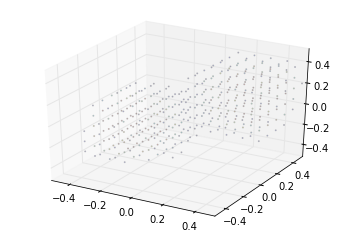

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

reference = exposure > 80
colour = exposure[reference]
colour[colour > 200] = 200

ax.scatter(
    x[reference], y[reference], z[reference], 
    alpha=0.2, s=1, c=colour, cmap=cm.jet)


ax.set_xlim([np.min(x_), np.max(x_)])
ax.set_ylim([np.min(y_), np.max(y_)])
ax.set_zlim([np.min(z_), np.max(z_)])

Create function to display the results of the optimisation as it is being calculated.

In [26]:
def display_results(dwell_times):
    dwell_times = np.reshape(dwell_times, (1, num_relevant_dwells))
    exposure = calculate_exposure(dwell_times)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    reference = exposure > 25
    colour = exposure[reference]
    colour[colour > 100] = 100
    
    small = exposure[reference] < 50
    large = ~small

    ax.scatter(
        x[reference][small], y[reference][small], z[reference][small], 
        alpha=0.2, s=3, c=colour[small], cmap=green_cm)
    
    ax.scatter(
        x[reference][large], y[reference][large], z[reference][large], 
        alpha=0.4, s=20, c=colour[large], cmap=green_cm)


    ax.set_xlim([np.min(x_), np.max(x_)])
    ax.set_ylim([np.min(y_), np.max(y_)])
    ax.set_zlim([np.min(z_), np.max(z_)])
    
    cost_function(dwell_times, debug=True)
    
    plt.show()

### Create the optimisation cost function

The maximum exposure to a grid position not within the target is aimed to be less than 60. This cost function aims to achieve this.

(0, 20)

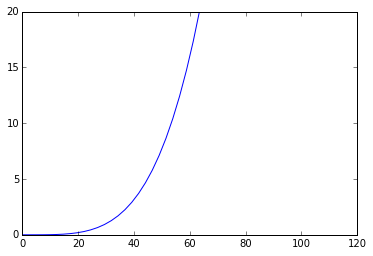

In [27]:
def hot_exterior_cost_function(max_target_exterior):
    return ((max_target_exterior)/30)**4

testx = np.linspace(0, 120)
testy = hot_exterior_cost_function(testx)
plt.plot(testx, testy)

plt.ylim([0, 20])

No grid point within the target is to be less than about 50. This cost function aims to achieve this.

(0, 20)

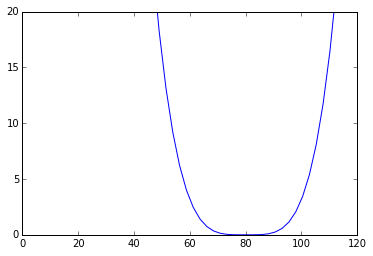

In [28]:
def cold_target_cost_function(min_target):
    return ((min_target-80)/15)**4

testx = np.linspace(0, 120)
testy = cold_target_cost_function(testx)
plt.plot(testx, testy)

plt.ylim([0, 20])

The avoid cost function aims to make no point within the avoid structure more than 45.

(0, 20)

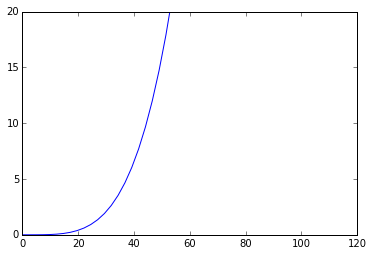

In [29]:
def hot_avoid_cost_function(max_avoid):
    return ((max_avoid)/25)**4

testx = np.linspace(0, 120)
testy = hot_avoid_cost_function(testx)
plt.plot(testx, testy)

plt.ylim([0, 20])

Create the cost function to be used by the optimiser

In [30]:
def cost_function(dwell_times, debug=False):
    dwell_times = np.reshape(dwell_times, (1, num_relevant_dwells))
    exposure = calculate_exposure(dwell_times)
    
    min_target = np.min(exposure[target_cube])
    max_avoid = np.max(exposure[avoid_cube])
    max_target_exterior = np.max(exposure[~target_cube])
    
    cold_target_cost = cold_target_cost_function(min_target)
    hot_exterior_cost = hot_exterior_cost_function(max_target_exterior)
    hot_avoid_cost = hot_avoid_cost_function(max_avoid)
    
    total_cost = hot_exterior_cost + cold_target_cost + hot_avoid_cost
    
    if debug:
        print("Minimum target = %0.4f, resulting cost = %0.4f" %
              (min_target, cold_target_cost))
        print("Maximum exterior = %0.4f, resulting cost = %0.4f" %
              (max_target_exterior, hot_exterior_cost))
        print("Maximum avoid = %0.4f, resulting cost = %0.4f" %
              (max_avoid, hot_avoid_cost))
        print("Total cost = %0.4f" % (total_cost))
        
    
    return total_cost

Create initial conditions

In [31]:
num_relevant_dwells

126

In [32]:
initial_conditions = np.ones(num_relevant_dwells)*0.1

Step noise

In [33]:
step_noise = np.ones(num_relevant_dwells) * 0.3

Bounds

In [34]:
bounds = ((0, None),)*num_relevant_dwells

Run the optimiser

In [35]:
optimisation = BasinhoppingWrapper(
    to_minimise=cost_function,
    initial=initial_conditions,
    step_noise=step_noise,
    basinhopping_confidence=2,
    optimiser_confidence=0.0001,
    n=5,
    debug=display_results,
    bounds=bounds
)

KeyboardInterrupt: 

## Presentation of results

In [ ]:
display_results(optimisation.result)

Display histogram of resulting dwell times

In [ ]:
plt.hist(optimisation.result)

Give overview of dwell times segmented by catheter

In [ ]:
for line_num in range(number_of_lines):
    
    print("Line number %d" % (line_num))
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(
        x[target_cube], y[target_cube], z[target_cube], 
        alpha=0.2, s=2, color='blue')
    ax.scatter(
        x[avoid_cube], y[avoid_cube], z[avoid_cube], 
        alpha=0.2, s=2, color='red')
    
    ref = line_number_index == line_num
    ax.scatter(*np.transpose(relevant_dwell_positions[ref]), 
               c=line_colours[line_num], alpha=0.7)


    ax.set_xlim([np.min(x_), np.max(x_)])
    ax.set_ylim([np.min(y_), np.max(y_)])
    ax.set_zlim([np.min(z_), np.max(z_)])
    
    plt.show() 
    
    
    plt.scatter(np.arange(np.sum(ref)), optimisation.result[ref],
               c=line_colours[line_num])
    plt.xlabel("Dwell number")
    plt.ylabel("Units of dwell time")
    
    plt.ylim(bottom=0)
    plt.show()

Convert result into column vector for post analysis

In [ ]:
dwell_times = np.reshape(optimisation.result, (1, num_relevant_dwells))

Create a custom resolution exposure calculation function for post analysis

In [ ]:
def create_calculate_exposure(dwell_positions, 
                              x_new=None, y_new=None, z_new=None):
    x, y, z = np.meshgrid(
        x_new, y_new, z_new)
    x = np.ravel(x)
    y = np.ravel(y)
    z = np.ravel(z)

    distance_to_dwell_pos = np.array([
        np.sqrt(
            (x[i] - dwell_positions[:,0])**2 + 
            (y[i] - dwell_positions[:,1])**2 + 
            (z[i] - dwell_positions[:,2])**2
        )
        for i in range(len(x))
    ])

    exposure_per_unit_time = 1 / distance_to_dwell_pos**2
    
    def calculate_exposure(dwell_times, reshape=False):
        exposure = np.sum(dwell_times * exposure_per_unit_time, axis=1)
        if reshape:
            exposure = np.reshape(exposure, (
                len(x_new), len(y_new), len(z_new)))
        return exposure
        
    return calculate_exposure

In [ ]:
dx = 0.01; dy = 0.01

contour_x_ = np.arange(np.min(x_), np.max(x_) + dx, dx)
contout_y_ = np.arange(np.min(y_), np.max(y_) + dy, dy)
contout_z_ = z_

contour_calculate_exposure = create_calculate_exposure(
    relevant_dwell_positions, x_new=contour_x_, y_new=contout_y_, z_new=contout_z_)

contour_exposure = contour_calculate_exposure(dwell_times, reshape=True)
contour_exposure[contour_exposure > 250] = 250

In [ ]:
for i, z_value in enumerate(z_):
    plt.figure(figsize=(6,6))
    
    c = plt.contourf(contour_x_, contout_y_,
        contour_exposure[:, :, i], 250,
        vmin=0, vmax=100, cmap=green_cm)
    
    reference = z[target_cube] == z_value
    x_target = x[target_cube][reference]
    y_target = y[target_cube][reference]
    plt.scatter(x_target, y_target, alpha=0.3, color='blue')
    
    reference = z[avoid_cube] == z_value
    x_avoid = x[avoid_cube][reference]
    y_avoid = y[avoid_cube][reference]
    plt.scatter(x_avoid, y_avoid, alpha=0.3, color='red')
    
    plt.title("Slice z = %0.1f" % (z_value))
#     plt.colorbar(c)
    plt.xlim([np.min(x_), np.max(x_)])
    plt.ylim([np.min(y_), np.max(y_)])
    plt.show()

## Analysis of results

Create analysis grid

In [ ]:
dx = 0.02
dy = 0.02
dz = 0.02

post_x_ = np.arange(np.min(x_), np.max(x_) + dx, dx)
post_y_ = np.arange(np.min(y_), np.max(y_) + dy, dy)
post_z_ = np.arange(np.min(z_), np.max(z_) + dz, dz)

post_x, post_y, post_z = np.meshgrid(
    post_x_, post_y_, post_z_)
post_x = np.ravel(post_x)
post_y = np.ravel(post_y)
post_z = np.ravel(post_z)

post_calculate_exposure = create_calculate_exposure(
    relevant_dwell_positions, x_new=post_x_, y_new=post_y_, z_new=post_z_)

post_exposure = post_calculate_exposure(dwell_times)

Define structures on new finer grid

In [ ]:
post_target_cube = target(post_x, post_y, post_z)
post_avoid_cube = avoid(post_x, post_y, post_z)

Make a function to plot DVHs given a reference

In [ ]:
def create_dvh(reference, exposure, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
    
    results = exposure[reference]
    results[results>150] = 150
    hist = np.histogram(results, 100)
    
    freq = hist[0]
    bin_edge = hist[1]
    bin_mid = (bin_edge[1::] + bin_edge[:-1:])/2
    
    cumulative = np.cumsum(freq[::-1])
    cumulative = cumulative[::-1]
    bin_mid = np.append([0], bin_mid)
    
    cumulative = np.append(cumulative[0], cumulative)
    percent_cumulative = cumulative / cumulative[0] * 100

    ax.plot(bin_mid, percent_cumulative)

Plotting of relevant DVHs

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

create_dvh(post_target_cube, post_exposure, ax=ax)
create_dvh(post_avoid_cube, post_exposure, ax=ax)
create_dvh(~post_target_cube, post_exposure, ax=ax)

plt.legend(["Target", "Avoid", "Patient"])

plt.xlim([0, 150])

Add a random shift to each catheter, see the effect it has on target DVH.

In [ ]:
relevant_dwell_distances = np.ravel(dwell_distances)[is_dwell_closest_to_target]
shift_uncertainty = 0.05

In [ ]:
line_displacement = np.random.normal(scale=shift_uncertainty, size=number_of_lines)

In [ ]:
shifted_dwell_positions = np.array([
    find_distance_coords(
        distance=relevant_dwell_distances[i] + line_displacement[line_number_index[i]], 
        line_num=line_number_index[i])
    for i in range(len(relevant_dwell_distances))
])

In [ ]:
shifted_calculate_exposure = create_calculate_exposure(
    shifted_dwell_positions, x_new=post_x_, y_new=post_y_, z_new=post_z_)

shifted_exposure = shifted_calculate_exposure(dwell_times)

With the shift the change in the DVH is the following. For the optimisation given here there is very little change in DVH.

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

create_dvh(post_target_cube, post_exposure, ax=ax)
create_dvh(post_target_cube, shifted_exposure, ax=ax)

plt.legend(["Original", "With position error"], loc='lower left')

plt.xlim([0, 110])

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

create_dvh(post_avoid_cube, post_exposure, ax=ax)
create_dvh(post_avoid_cube, shifted_exposure, ax=ax)

plt.legend(["Original", "With position error"], loc='upper right')

plt.xlim([0, 110])